<a href="https://colab.research.google.com/github/ahackv/mogig/blob/main/src/analysis/uv_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Simulated Data Sample ---
         shield_material            altitude_segment  uv_exposure_score
0          Thick Plastic       Low Altitude (Ground)           8.434995
1  Sunscreen Film Type A  High Altitude (Near Space)          14.076855
2                  Glass  High Altitude (Near Space)          49.526895
3  Sunscreen Film Type A  High Altitude (Near Space)          13.606758
4  Sunscreen Film Type B       Low Altitude (Ground)           0.941912

Shape of simulated data: (300, 3)

--- Training Model ---
Model training complete.
Model OOB Score: 0.9869

--- Evaluating Model ---
Test Set Mean Squared Error (MSE): 6.25
Test Set Root Mean Squared Error (RMSE): 2.50
Test Set Mean Absolute Error (MAE): 1.68
Test Set R-squared (R²): 0.99


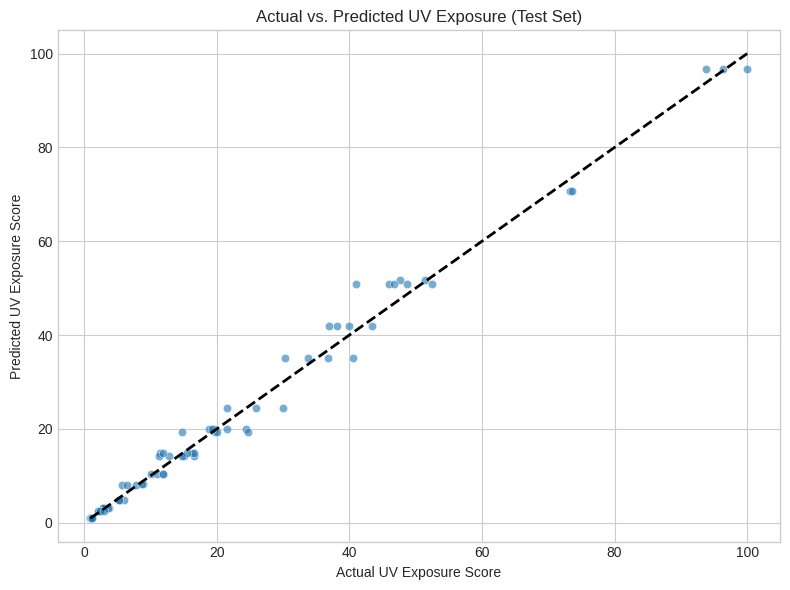

<ipython-input-1-db1256d11bda>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette="viridis")


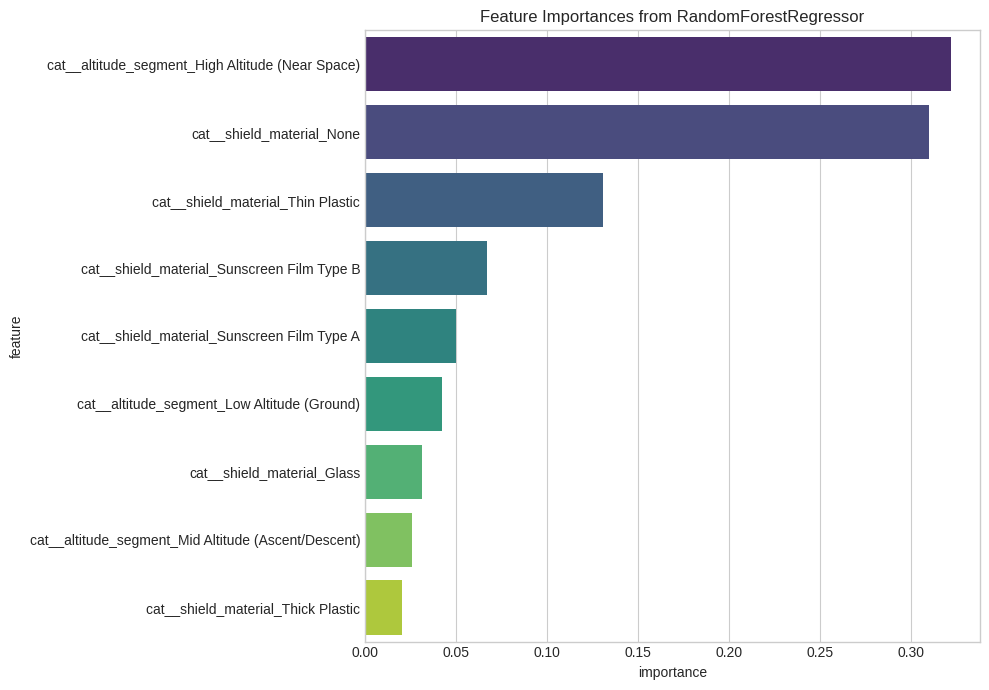

<ipython-input-1-db1256d11bda>:161: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="predicted_uv_exposure", y="shield_material", data=ranking_df, palette="coolwarm_r") # _r reverses palette


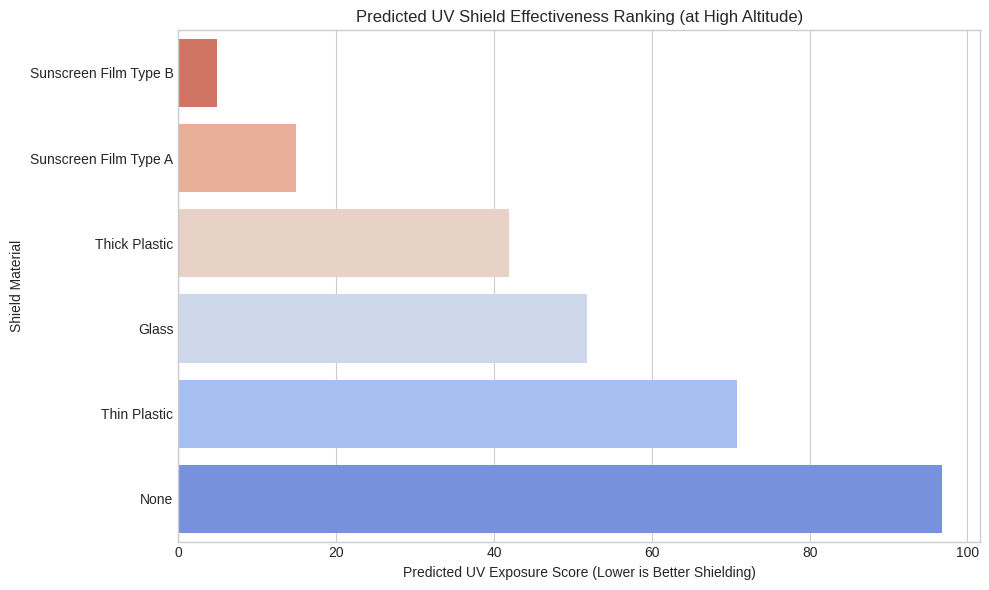

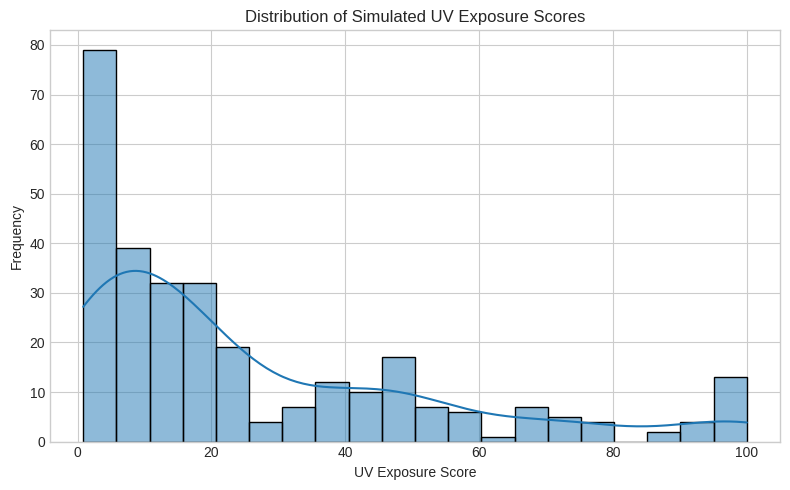

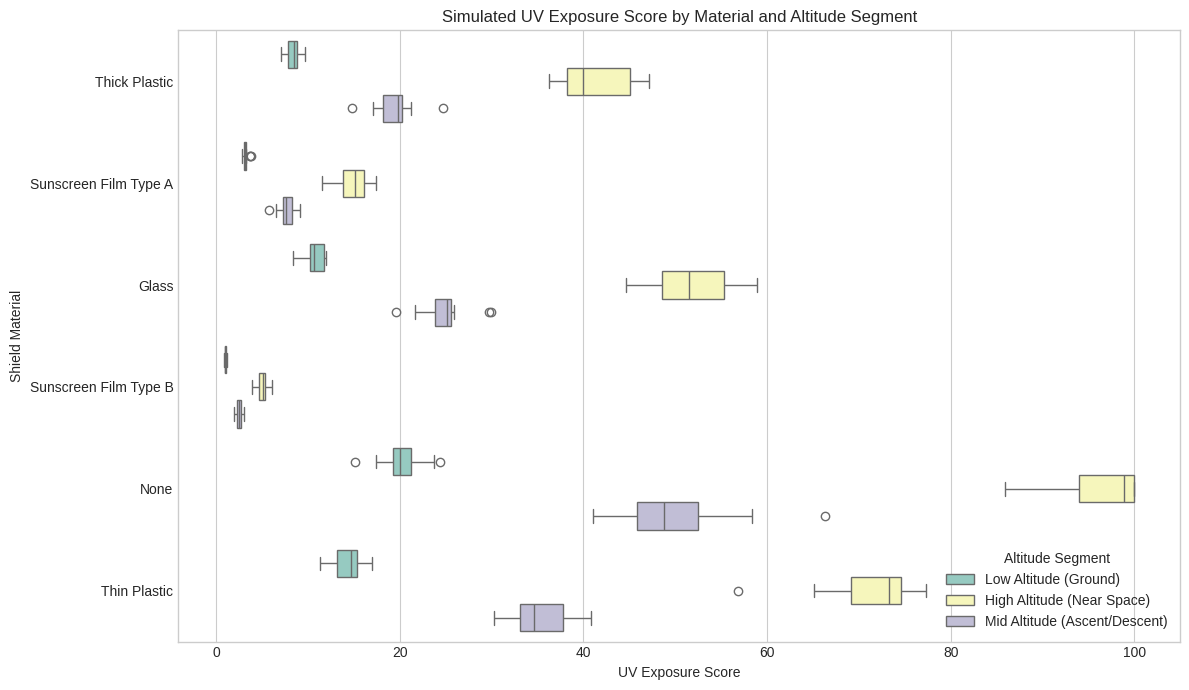


--- Script Finished ---
The plots show model performance and insights.
The 'Predicted UV Shield Effectiveness Ranking' plot shows which materials the model thinks are best, based on simulated data.
After your flight, you would replace simulated 'uv_exposure_score' with actual measurements from your UV beads and retrain/test.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Simulate Data ---
def simulate_uv_data(num_samples=200):
    """Generates simulated data for UV exposure based on shield material and altitude."""
    np.random.seed(42) # for reproducibility

    shield_materials = ["None", "Glass", "Thin Plastic", "Thick Plastic", "Sunscreen Film Type A", "Sunscreen Film Type B"]
    # Effectiveness: 1.0 = no shielding, 0.1 = very effective shielding
    shield_effectiveness = {
        "None": 1.0,
        "Glass": 0.5, # Blocks some UV, especially UVB
        "Thin Plastic": 0.7,
        "Thick Plastic": 0.4,
        "Sunscreen Film Type A": 0.15,
        "Sunscreen Film Type B": 0.05, # Most effective
    }

    # Simulate different altitude segments, as UV is stronger higher up
    altitude_segments = ["Low Altitude (Ground)", "Mid Altitude (Ascent/Descent)", "High Altitude (Near Space)"]
    altitude_uv_factor = {
        "Low Altitude (Ground)": 1.0,
        "Mid Altitude (Ascent/Descent)": 2.5,
        "High Altitude (Near Space)": 5.0, # Significantly more UV
    }

    data = []
    base_uv_intensity = 20 # An arbitrary base unit for UV exposure

    for _ in range(num_samples):
        material = np.random.choice(shield_materials)
        altitude_seg = np.random.choice(altitude_segments)

        # Calculate base exposure at this altitude
        current_base_uv = base_uv_intensity * altitude_uv_factor[altitude_seg]

        # Apply shield effectiveness
        exposure_score = current_base_uv * shield_effectiveness[material]

        # Add some random noise to make it more realistic for a model
        noise = np.random.normal(0, exposure_score * 0.1) # 10% noise relative to score
        exposure_score = max(0, min(100, exposure_score + noise)) # Clamp between 0 and 100

        data.append({
            "shield_material": material,
            "altitude_segment": altitude_seg,
            "uv_exposure_score": exposure_score
        })

    return pd.DataFrame(data)

# Generate the simulated data
df_simulated = simulate_uv_data(num_samples=300)
print("--- Simulated Data Sample ---")
print(df_simulated.head())
print(f"\nShape of simulated data: {df_simulated.shape}")

# --- 2. Preprocess Data ---
# Define features (X) and target (y)
X = df_simulated[["shield_material", "altitude_segment"]]
y = df_simulated["uv_exposure_score"]

# Identify categorical features for one-hot encoding
categorical_features = ["shield_material", "altitude_segment"]

# Create a preprocessor object using ColumnTransformer
# This will apply OneHotEncoding to categorical features and pass through others (if any)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # In case we add numerical features later
)

# --- 3. Train a Model ---
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a pipeline that first preprocesses the data, then trains a RandomForestRegressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True))
])

# Train the model
print("\n--- Training Model ---")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")
if hasattr(model_pipeline.named_steps['regressor'], 'oob_score_'):
    print(f"Model OOB Score: {model_pipeline.named_steps['regressor'].oob_score_:.4f}")


# --- 4. Evaluate the Model ---
print("\n--- Evaluating Model ---")
y_pred_test = model_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mse)

print(f"Test Set Mean Squared Error (MSE): {mse:.2f}")
print(f"Test Set Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Test Set Mean Absolute Error (MAE): {mae:.2f}")
print(f"Test Set R-squared (R²): {r2:.2f}")

# --- 5. Visualize Results ---
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style

# Plot 1: Actual vs. Predicted UV exposure
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel("Actual UV Exposure Score")
plt.ylabel("Predicted UV Exposure Score")
plt.title("Actual vs. Predicted UV Exposure (Test Set)")
plt.tight_layout()
plt.show()

# Plot 2: Feature Importances
# Get feature names after one-hot encoding
feature_names_out = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = model_pipeline.named_steps['regressor'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names_out,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette="viridis")
plt.title("Feature Importances from RandomForestRegressor")
plt.tight_layout()
plt.show()

# Plot 3: Model's Predicted UV Exposure by Shield Material (Ranking)
# To rank materials, let's predict for a consistent "High Altitude" scenario
unique_materials = df_simulated["shield_material"].unique()
ranking_data = []
for material in unique_materials:
    # Create a DataFrame for prediction for this material at high altitude
    pred_df = pd.DataFrame({
        "shield_material": [material],
        "altitude_segment": ["High Altitude (Near Space)"]
    })
    predicted_score = model_pipeline.predict(pred_df)[0]
    ranking_data.append({"shield_material": material, "predicted_uv_exposure": predicted_score})

ranking_df = pd.DataFrame(ranking_data).sort_values(by="predicted_uv_exposure", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="predicted_uv_exposure", y="shield_material", data=ranking_df, palette="coolwarm_r") # _r reverses palette
plt.xlabel("Predicted UV Exposure Score (Lower is Better Shielding)")
plt.ylabel("Shield Material")
plt.title("Predicted UV Shield Effectiveness Ranking (at High Altitude)")
plt.tight_layout()
plt.show()

# Plot 4: Distribution of Simulated UV Exposure Scores (Original Data)
plt.figure(figsize=(8, 5))
sns.histplot(df_simulated["uv_exposure_score"], kde=True, bins=20)
plt.title("Distribution of Simulated UV Exposure Scores")
plt.xlabel("UV Exposure Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot 5: Box plot of simulated UV exposure by material (to verify simulation)
plt.figure(figsize=(12, 7))
sns.boxplot(x="uv_exposure_score", y="shield_material", data=df_simulated, hue="altitude_segment", palette="Set3")
plt.title("Simulated UV Exposure Score by Material and Altitude Segment")
plt.xlabel("UV Exposure Score")
plt.ylabel("Shield Material")
plt.legend(title="Altitude Segment", loc="lower right")
plt.tight_layout()
plt.show()

print("\n--- Script Finished ---")
print("The plots show model performance and insights.")
print("The 'Predicted UV Shield Effectiveness Ranking' plot shows which materials the model thinks are best, based on simulated data.")
print("After your flight, you would replace simulated 'uv_exposure_score' with actual measurements from your UV beads and retrain/test.")